<a href="https://colab.research.google.com/github/peterjsadowski/Tutorial-Microbiome/blob/main/part2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Microbiome Data Analysis

This notebook presents a tutorial on using machine learning with sklearn for analyzing microbiome amplicon data.

Author: Peter Sadowski

Date: Feb 19 2023


# Loading Data

For this example we use samples taken by UH Professor Anthony Amend's BOT662 class. Instructions:
1. Download file from [this link](https://drive.google.com/drive/u/0/folders/1ueHCzkohAkXOW-ZcbqDgeLr8PnQ5Rxyd) (Google login required).
1. Upload the zip file 'Class_Data_for_Phyloseq.zip' to the runtime.
1. Unzip it below.

In [ ]:
!unzip Class_Data_for_Phyloseq.zip  # Assumes file is saved locally.

In [9]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pylab as plt

# Load data into pandas dataframe.
df = pd.read_csv('OTUs.100.rep.count_table.csv')
df = df.rename(columns={'Unnamed: 0': 'OTU'})
df = df.set_index('OTU')

# Load meta data into separate dataframe
meta_data = pd.read_csv('brom_meta.csv')
meta_data = meta_data.set_index('sample_name')

# Supervised machine learning

In supervised learning, the goal is to predict some target variable _y_ from some input variable _x_. In a probabilistic machine learning model, the predictions will be in the form of a conditional probability distribution p(y|x), where this might be a discrete probability mass function over a finite set of class labels (classification) or a probability density function over real values (regression). Classification is more concrete, so we focus on it here.


# Logistic Regression Classifier
Below we use a simple __logistic regression__ classifier to predict the sample_type from amplicon counts. 



In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

def assign_colors(df, meta_data, colorby='sample_type'):
  """ Assign a integer label and color to each unique value in the colorby col.
  Returns:
    labels = List of labels. Has length equal to len(df.columns).
    labels_int = List of integer labels.
    colors = List of colors. Has length equal to len(df.columns).
    label_colors = Dict mapping unique keys to colors.
  """
  labels = [meta_data.loc[[sample_name]][colorby][0]
          for sample_name in df.columns]
  encoder = LabelEncoder()
  labels_int = encoder.fit_transform(labels)
  cmap = plt.get_cmap('Accent')
  num_labels = len(np.unique(labels))
  label_colors = {label: cmap(i/num_labels) 
                  for i, label in enumerate(np.unique(labels))}
  colors = [label_colors[label] for label in labels]
  return labels, labels_int, colors, label_colors

labels, labels_int, colors, label_colors = assign_colors(
    df, meta_data, colorby='sample_type')

# Classification task is to predict sample_type from 
X = (np.log(1+df).T).to_numpy()
y = labels_int 

clf = LogisticRegression(random_state=0, penalty='l2', max_iter=1000).fit(X, y)
# This function predicts the most likely class label.
labels_predicted = clf.predict(X[:, :])
# This function gives probabilities for each class.
probs_predicted = clf.predict_proba(X[:, :])

print(f'Accuracy: {clf.score(X, y) * 100}%')

Accuracy: 100.0%


## Cross-Validation
This model gets 100% accuracy on our little dataset of 22 examples. Is that good? We _don't know_ without testing it on new data! Machine learning models, even simple ones like this linear model, are prone to __overfit__ to the data they are trained on. A powerful model can _always_ get 100% on the training data, but that doesn't mean the model __generalizes__ to new examples (which is the only thing we ever care about). Thus, the standard way to evaluate ML models is through __cross-validation__ where the data is separated into a __training set__ that is used to fit the model and __test set__ that is only used for evaluating the model performance.

Scikit learn has some very helpful methods managing these data splits. For example, train_test_split method splits off 40% of the data to be in the test set.


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf = LogisticRegression(penalty='l2', max_iter=1000).fit(X_train, y_train)
print(f'Accuracy: {clf.score(X_test, y_test) * 100}%')

Accuracy: 33.33%


This is far less than the 100% accuracy from before. This shouldn't be surprising, since we are only training on ~13 examples! Isn't there a way to use more of our tiny dataset for training? Unfortunatley, if we decrease the size of our test set, we get a very noisy estimate of the performance. Indeed, if the test set contains only one example, then the accuracy estimate will be either 0% or 100%.

There is a nice trick that gives us the best of both worlds, at the cost of more computation. In __K-fold cross-validation__, we split the data into k subsets, and train k models, using a different subset for testing each iteration. In the extreme case where k is the number of samples in the dataset, this is called __leave-one-out cross validation__.  

In [47]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(random_state=0, penalty='l2', max_iter=1000)
%timeit scores = cross_val_score(clf, X, y, cv=5)
print(f'CV accuracies: {scores}')
print(f'Mean accuracy: {scores.mean():.2f}')  # prints only two decimals

4.93 s ± 529 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CV accuracies: [0.6  0.8  1.   1.   0.75]
Mean accuracy: 0.83


By default, Scikit Learn attempts to do __stratified cross-validation__, in which the examples in each class are evenly distributed between the k-folds. 

In order to do leave-one out cross-validation, we can pass the LeaveOneOut iterator object to cross_val_score. Notice that this takes a minute to run, because it is training 22 different models. 

In [40]:
from sklearn.model_selection import LeaveOneOut
clf = LogisticRegression(random_state=0, penalty='l2', max_iter=1000)
%timeit scores = cross_val_score(clf, X, y, cv=LeaveOneOut())
print(f'CV accuracies: {scores}')
print(f'Mean accuracy: {scores.mean():.2f}')

25 s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
CV accuracies: [0.6  0.8  1.   1.   0.75]
Mean accuracy: 0.8300000000000001


# Decision Trees

One of the most intuitive and interpretable machine learning algorithms is the decision tree. Training a decision tree consists of iteratively splitting the data into smaller subsets, with final predictions made at the __leaf nodes__ of the tree.

Decision trees are __greedy algorithms__ because trees are constructed by choosing the optimal split at each decision node without worrying about the rest of the tree. There are different ways to define the splitting criterion (common criteria are 'gini' and 'entropy'). 

![]() <img src="https://www.simplilearn.com/ice9/free_resources_article_thumb/decision-tree.JPG"  width="350">

Another parameter that should be specified is the maximum depth of the decision tree. If the tree is allowed to keep growing, it will eventually overfit to the training data. This is shown in the figure below, where the training accuracy (score) increases as the max_depth of the tree goes to 50, but the test accuracy is maximum at max_depth=8.

![]() <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3363480%2Faff30b8b45ec7863877627604190472d%2FCapture.PNG?generation=1569874571729138&alt=media"  width="400">

Lets try training a decision tree on the microbiome data. We use a max_depth of three, and the default 'gini' criterion. 



Accuracy on training set: 0.91


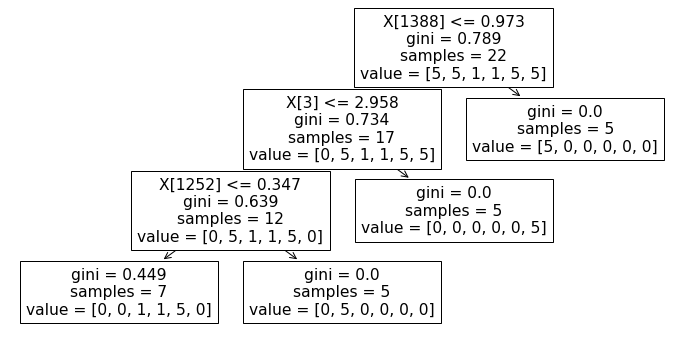

In [20]:
from sklearn import tree

# Suppress those warnings about having a class with only one example.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)
print(f'Accuracy on training set: {clf.score(X,y):.2f}')

# Visualize tree
plt.figure(figsize=(12,6))
tree.plot_tree(clf);


# Hyperparameter Selection

How do we choose the max_depth of our decision tree and the splitting criteria? These are known as __hyperparameters__ of the model, because unlike the parameters of the model which are _learned_ by the training algorithm from data, these must be specified by the practitioner. 

In practice, we select hyperparameters using a combination of intuition and optimization. Intuition tells us which hyperparameter choices are reasonable for our data (for example, a decision tree with max_depth>5 will horribly overfit the small microbiome dataset). We can also optimize hyperparameters by trying many different combinations, and using cross-validation to evaluate performance on held-out data.

Below we perform a hyperparameter optimization to choose the max_depth parameter. 

Text(0, 0.5, 'Accuracy')

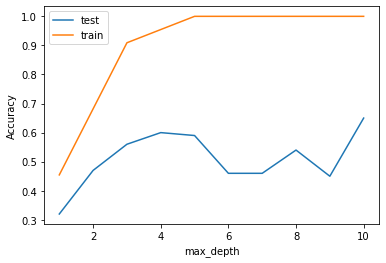

In [42]:
from sklearn.model_selection import cross_val_score

max_depth_choices = np.arange(10) + 1
test_accuracy_mean = np.zeros_like(max_depth_choices, dtype='float')
train_accuracy = np.zeros_like(max_depth_choices, dtype='float')
for i, max_depth in enumerate(max_depth_choices):
  clf = tree.DecisionTreeClassifier(max_depth=max_depth)
  scores = cross_val_score(clf, X, y, cv=5)
  test_accuracy_mean[i] = scores.mean()
  train_accuracy[i] = clf.fit(X,y).score(X,y)

plt.plot(max_depth_choices, test_accuracy_mean, label='test')
plt.plot(max_depth_choices, train_accuracy, label='train')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


#  Random Forests

Decision trees only look at feature at a time. This makes them easy to interpret, but it means they ignore most of the other features. A __random forest__ is a set of decision trees that are trained on different subsets of the features, and predictions are averaged together. Random forests work well in practice, but require more computation.

Lets do an example.

In [45]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3, n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
print(f'CV accuracies: {scores}')
print(f'Mean accuracy: {scores.mean():.2f}')

CV accuracies: [0.6  0.6  1.   1.   0.75]
Mean accuracy: 0.79


Now lets perform the same hyperparameter optimization experiment that we did with the decision trees, to see how sensitive the model is to the choice of max_depth. 

Text(0, 0.5, 'Accuracy')

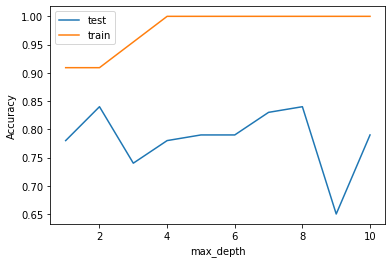

In [46]:
# Hyperparameter optimization of max_depth for random forest.
max_depth_choices = np.arange(10) + 1
test_accuracy_mean = np.zeros_like(max_depth_choices, dtype='float')
train_accuracy = np.zeros_like(max_depth_choices, dtype='float')

for i, max_depth in enumerate(max_depth_choices):
  clf = RandomForestClassifier(max_depth=max_depth, n_estimators=100)
  scores = cross_val_score(clf, X, y, cv=5)
  test_accuracy_mean[i] = scores.mean()
  train_accuracy[i] = clf.fit(X,y).score(X,y)

plt.plot(max_depth_choices, test_accuracy_mean, label='test')
plt.plot(max_depth_choices, train_accuracy, label='train')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


Notice that the RF is less sensitive to the max_depth parameter. The RF is a much more complex model (it contains 100 decision trees!), but it manages to avoid overfitting by randomly selecting different features for each individual tree. In practice, random forests are more accurate, but require more computation, both to train and when making predictions.



# Other models

Scikit learn has lots of other supervised learning models. No single model is best in every situation, an idea formalized by the [__No Free Lunch Theorem__](https://en.wikipedia.org/wiki/No_free_lunch_theorem). Machine learning works by "interpolating" between the training points, with the implicit assumption that the functions we are trying to learn are "smooth", and different models have different smoothness assumptions. The figure below shows the __decision boundaries__ different machine learning classifiers on three different training datasets. Notice how different these predictions can be. 

![]() <img src="https://scikit-learn.org/0.15/_images/plot_classifier_comparison_0011.png"  width="1000"> 

 These assumptions are usually _implicit_ and they are known as the model's __inductive bias__. To be clear, this inductive bias is not a bad thing --- inductive bias is necessary for learning --- but different models have different biases that lead to different predictions when trained on the same data. In practice, practicioners use cross-validation to perform __model selection__ to choose the best model for a particular problem. Scikit learn makes this easy by having many different models implemented using the same API.

